In [1]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

## DATASET

In [2]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

In [3]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path

    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)

    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

In [4]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

2340801/2340801 [==============================] - 0s 0us/step


In [5]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [6]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k\\Flicker8k_Dataset\\2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [7]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 2s 0us/step


In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [9]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [10]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [11]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [12]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [13]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [14]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [15]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [16]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

In [17]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [18]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [19]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [20]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [21]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [22]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [23]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [24]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [00:18, 10.03it/s]
32it [00:03, 10.59it/s]


In [25]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [26]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [27]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 34)
(32, 34)


In [28]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3 100  22 417  83   5   2 103 164   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[100  22 417  83   5   2 103 164   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


##ENCODER

In [29]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [30]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [31]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [32]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [34]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [35]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 156.78it/s]



Uniform entropy: 8.52
Marginal entropy: 5.29


In [36]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [37]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [38]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [39]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 1s 8us/step


In [40]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [41]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a
back white hut a a a a 2 the american and attire boy in brown the


In [42]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [43]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [44]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a in a a a a
in the plays children a



In [45]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [47]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 4.9947 - masked_acc: 0.2020

a man in a man in a man
a dog in a and a man in the in the man in the in the
a beach girl are snowy the standing to a dressed

100/100 [==============================] - 9s 58ms/step - loss: 4.9911 - masked_acc: 0.2023 - val_loss: 4.6355 - val_masked_acc: 0.2414
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.5997 - masked_acc: 0.2566

a man in a red in the water
a man is and a water
a woman touches in the bike as water high a field

100/100 [==============================] - 4s 45ms/step - loss: 4.5994 - masked_acc: 0.2566 - val_loss: 4.3839 - val_masked_acc: 0.2785
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.3746 - masked_acc: 0.2819

a man in a red is is in the water
a man in a playing on a beach
a bicycle pulling a

100/100 [==============================] - 4s 43ms/step - loss: 4.3746 - masked_acc: 0.2819 - val_loss: 4.1381 - val

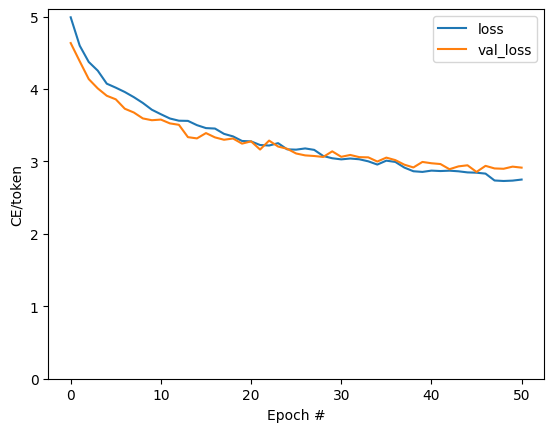

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

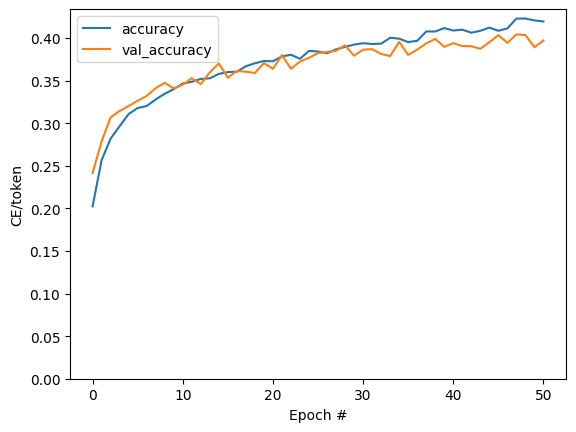

In [49]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [50]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing on a wave'

In [51]:
str_tokens = result.split()
str_tokens.append('[END]')

In [52]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 12, 49]), TensorShape([1, 2, 12, 49])]

In [53]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [54]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([0.99999994, 1.        , 0.99999994, 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.99999994], dtype=float32)>

In [55]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

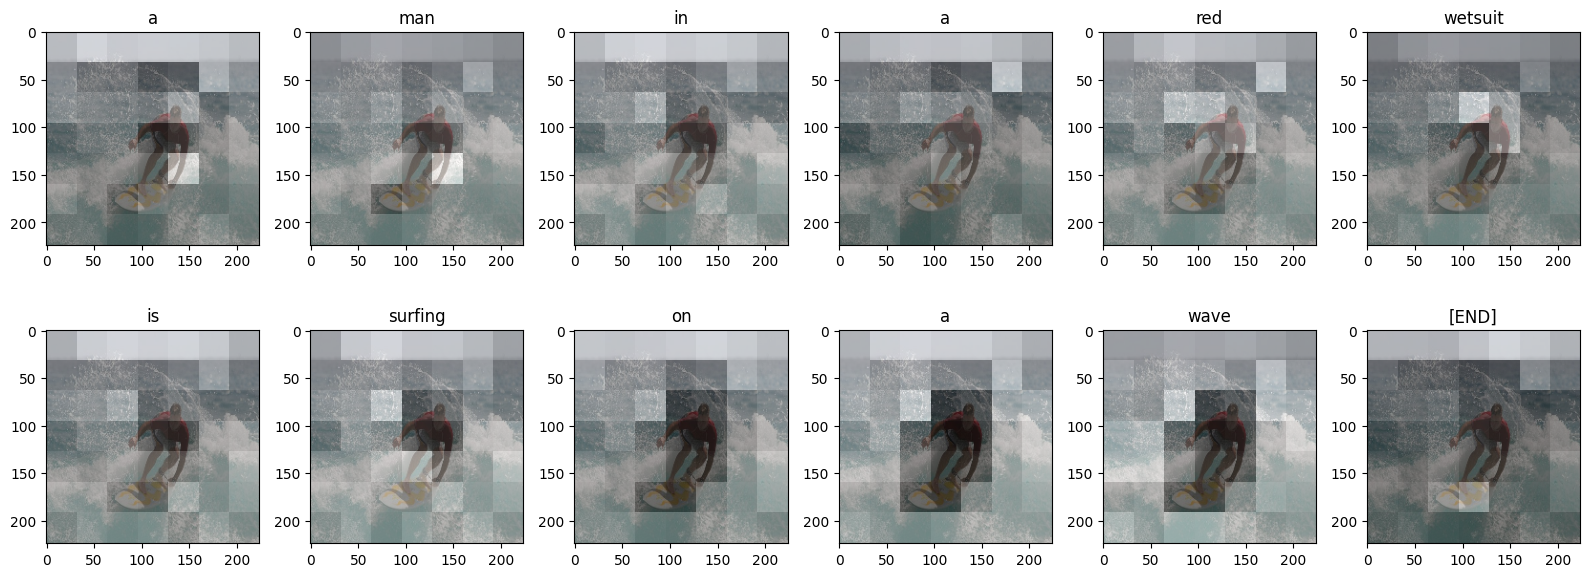

In [56]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [57]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


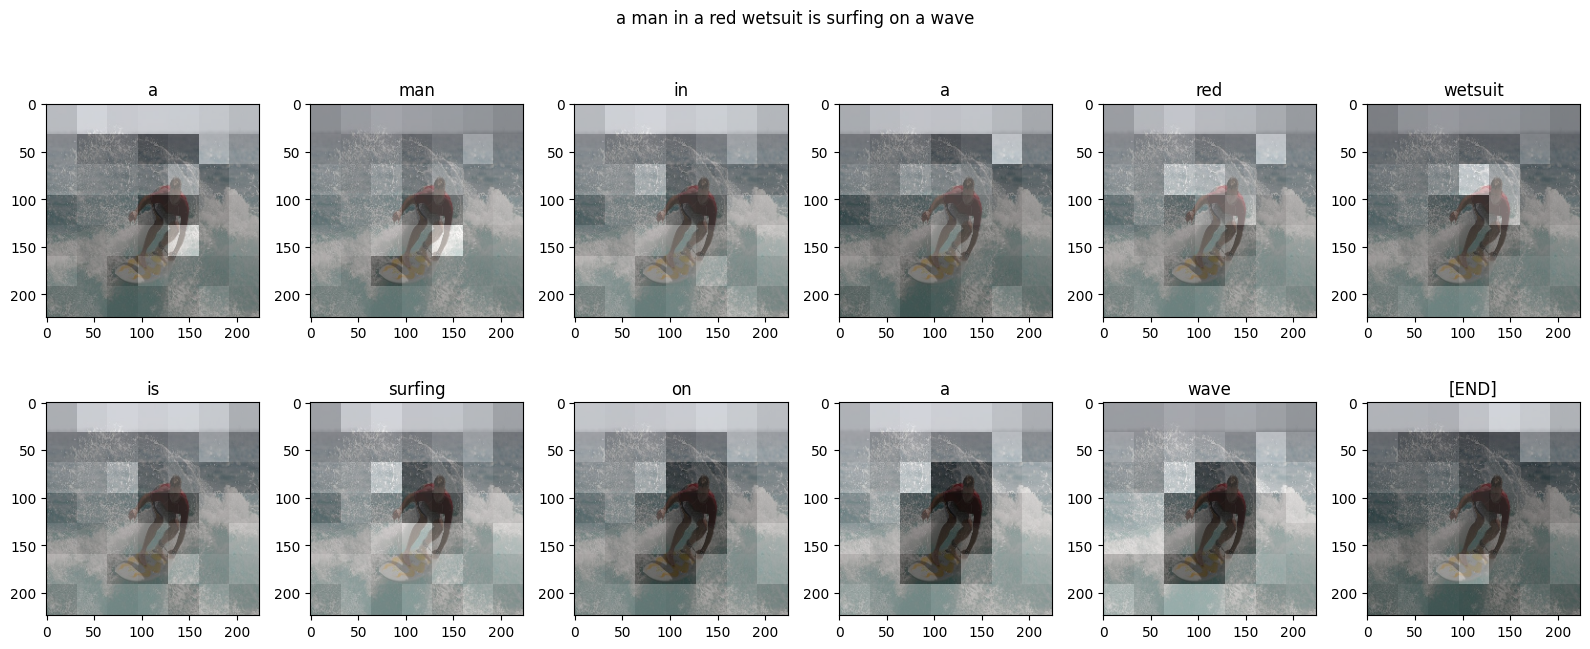

In [58]:
run_and_show_attention(model, image)